In [3]:
from matplotlib import pyplot as plt

import numpy as np
import os
import tensorflow as tf
import tensorflow.contrib.slim as slim
import urllib.request as urllib2

from tensorflow.contrib.slim.python.slim.nets import vgg
import vgg_preprocessing
import imagenet


# Load the mean pixel values and the function
# that performs the subtraction
from vgg_preprocessing import (_mean_image_subtraction, _R_MEAN, _G_MEAN, _B_MEAN)


checkpoints_dir = './'


In [4]:

# Function to nicely print segmentation results with
# colorbar showing class names
def discrete_matshow(data, labels_names=[], title=""):
    # get discrete colormap
    cmap = plt.get_cmap('Paired', np.max(data) - np.min(data) + 1)
    # set limits .5 outside true range
    mat = plt.matshow(data,
                      cmap=cmap,
                      vmin=np.min(data) - .5,
                      vmax=np.max(data) + .5)
    # tell the colorbar to tick at integers
    cax = plt.colorbar(mat,
                       ticks=np.arange(np.min(data), np.max(data) + 1))

    # The names to be printed aside the colorbar
    if labels_names:
        cax.ax.set_yticklabels(labels_names)

    if title:
        plt.suptitle(title, fontsize=14, fontweight='bold')

    plt.show()


Instructions for updating:
Use the `axis` argument instead
INFO:tensorflow:Restoring parameters from ./vgg_16.ckpt


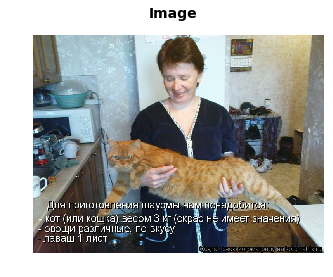

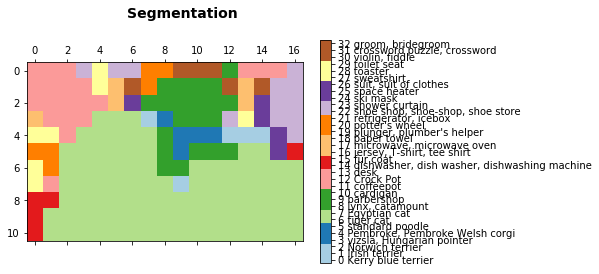

In [5]:
with tf.Graph().as_default():
    url = ("http://kotomatrix.ru/images/lolz/2010/12/09/760819.jpg")
#     url = ("https://upload.wikimedia.org/wikipedia/commons/d/d9/"
#            "First_Student_IC_school_bus_202076.jpg")

    image_string = urllib2.urlopen(url).read()
    
    
    image = tf.image.decode_jpeg(image_string, channels=3)

    # Convert image to float32 before subtracting the
    # mean pixel value
    image_float = tf.to_float(image, name='ToFloat')

    # Subtract the mean pixel value from each pixel
    processed_image = _mean_image_subtraction(image_float,
                                              [_R_MEAN, _G_MEAN, _B_MEAN])

    input_image = tf.expand_dims(processed_image, 0)

    with slim.arg_scope(vgg.vgg_arg_scope()):
        # spatial_squeeze option enables to use network in a fully
        # convolutional manner
        logits, _ = vgg.vgg_16(input_image,
                               num_classes=1000,
                               is_training=False,
                               spatial_squeeze=False)

    # For each pixel we get predictions for each class
    # out of 1000. We need to pick the one with the highest
    # probability. To be more precise, these are not probabilities,
    # because we didn't apply softmax. But if we pick a class
    # with the highest value it will be equivalent to picking
    # the highest value after applying softmax
    pred = tf.argmax(logits, dimension=3)

    init_fn = slim.assign_from_checkpoint_fn(
        os.path.join(checkpoints_dir, 'vgg_16.ckpt'),
        slim.get_model_variables('vgg_16'))

    with tf.Session() as sess:
        init_fn(sess)
        segmentation, np_image = sess.run([pred, image])
    
    # Show the downloaded image
    plt.figure()
    plt.imshow(np_image.astype(np.uint8))
    plt.suptitle("Image", fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.show()

# Remove the first empty dimension
segmentation = np.squeeze(segmentation)

# Let's get unique predicted classes (from 0 to 1000) and
# relable the original predictions so that classes are
# numerated starting from zero
unique_classes, relabeled_image = np.unique(segmentation,
                                            return_inverse=True)

segmentation_size = segmentation.shape

relabeled_image = relabeled_image.reshape(segmentation_size)

labels_names = []
names = imagenet.create_readable_names_for_imagenet_labels()
for index, current_class_number in enumerate(unique_classes):
    labels_names.append(str(index) + ' ' + names[current_class_number + 1])

discrete_matshow(data=relabeled_image, labels_names=labels_names, title="Segmentation")